In [1]:
library(tidyverse)
library(patchwork)
library(GGally)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
summary_all_common <- read_rds("summary_all_common.rds")
summary_all_common_diff <- read_rds("summary_all_common_diff.rds")
summary_all_common <- summary_all_common %>% 
    filter(Num_class <= 4) %>%
    mutate(class_id = as.factor(class_id)) %>%
    mutate(class_id = case_when(Model == "One_class" ~ "0", TRUE ~ class_id)) %>% 
    mutate(class_id = factor(class_id, levels = c("0", "1", "2", "3", "4")))

In [3]:
summary_all_common <- summary_all_common %>%
  mutate(GMM_pro = str_split(GMM_pro, ";", simplify = FALSE),
         GMM_mean = str_split(GMM_mean, ";", simplify = FALSE))

summary_all_common <- summary_all_common %>%
  mutate(Max_pro_pos = map_int(GMM_pro, ~which.max(as.numeric(.x))),
  GMM_Lmean = map2_dbl(GMM_mean, Max_pro_pos, ~as.numeric(.x[.y])))

summary_all_common <- summary_all_common %>%
    mutate(GC_content = map_dbl(real_base_freq, ~sum(as.numeric(.x[3:4]))/sum(as.numeric(.x[1:4]))))

In [4]:
theme_Publication <- function(base_size=14, base_family="helvetica") {
    theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.4, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          )
      
}


In [5]:
plot_rf <- summary_all_common %>% filter(Num_class <= 4) %>%
    ggplot(aes(x = as.factor(class_id), y = df_R)) +
    geom_count(aes(size = after_stat(prop))) +
  scale_size_area(max_size = 10) +
  theme_Publication() +
  labs(x = "Number of class on mixture model", y = "Degree of freedom of transition rate")

In [6]:
get_trace <- function(my_list){
  if(is.null(my_list)){
      return(NA)
  }else{
    sum(diag(matrix(unlist(my_list), nrow = 4, ncol = 4))) + 4  
  }
}

summary_all_common <- summary_all_common %>% 
    mutate(trace_Q = lapply(summary_all_common$Q, get_trace),
           sd_R = lapply(summary_all_common$R, function(x) sd(x, na.rm = TRUE)),
           sd_base_freq = lapply(summary_all_common$base_freq, function(x) sd(x, na.rm = TRUE)),
           Interval_base_freq =  lapply(summary_all_common$base_freq, function(x){max(x, na.rm = TRUE) - min(x, na.rm = TRUE)})) %>% 
    mutate(trace_Q = as.numeric(trace_Q),
           sd_R = as.numeric(sd_R),
           sd_base_freq = as.numeric(sd_base_freq),
           Interval_base_freq = as.numeric(Interval_base_freq)) %>% na.omit()

plot_tq <- summary_all_common %>% filter(Num_class <= 4) %>%
    ggplot(aes(x = as.factor(class_id), y = -trace_Q)) +
    geom_violin() +
    theme_Publication() +
    labs(x = "Number of class on mixture model", y = "-(trace(Q) + 4)") +
    ylim(-1,4)

In [7]:
plot_if <- summary_all_common %>% filter(Num_class <= 4) %>%
    ggplot(aes(x = as.factor(class_id), y = Interval_base_freq)) +
    geom_violin() +
    theme_Publication() +
    labs(x = "Number of class on mixture model", y = "Interval_base_freq")

Warning message:
“Removed 473 rows containing non-finite values (`stat_ydensity()`).”


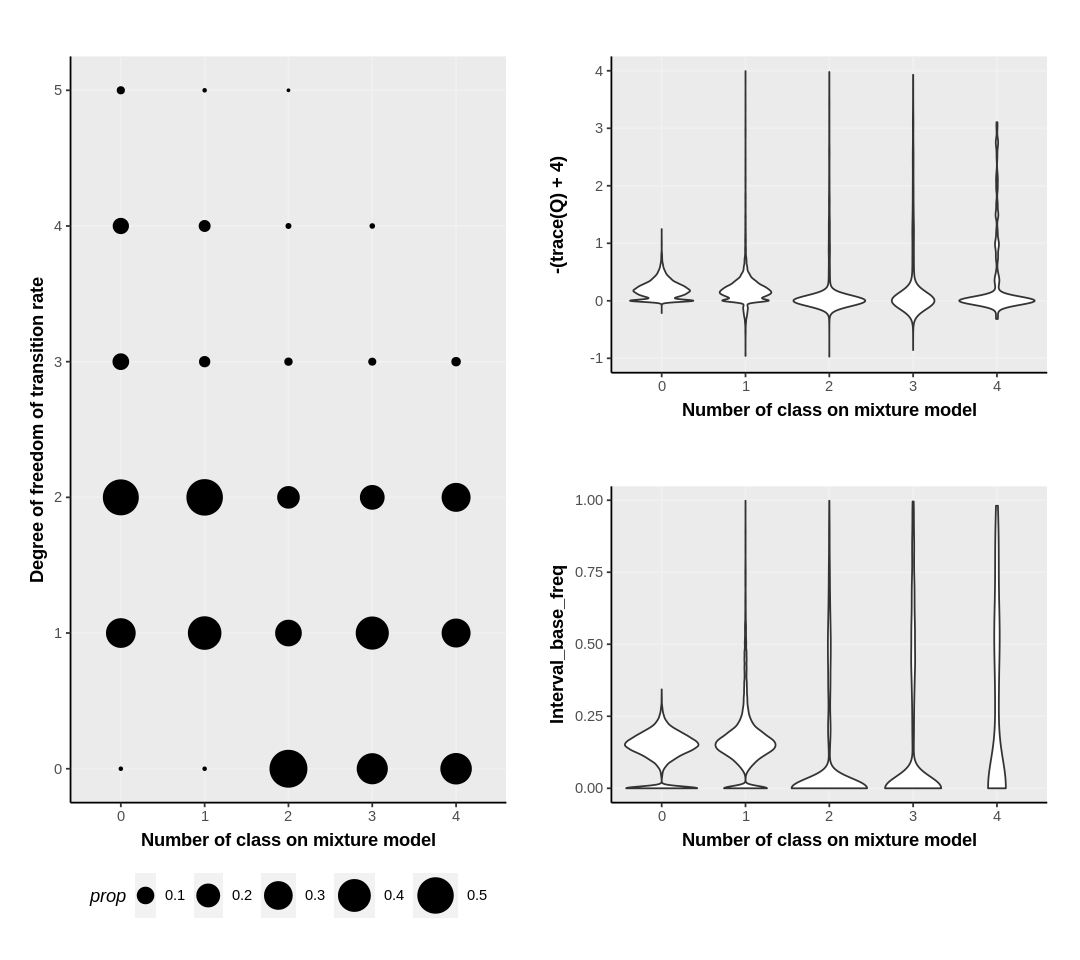

In [8]:
options(repr.plot.width = 9, repr.plot.height = 8)
plot_rf + plot_tq / plot_if

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


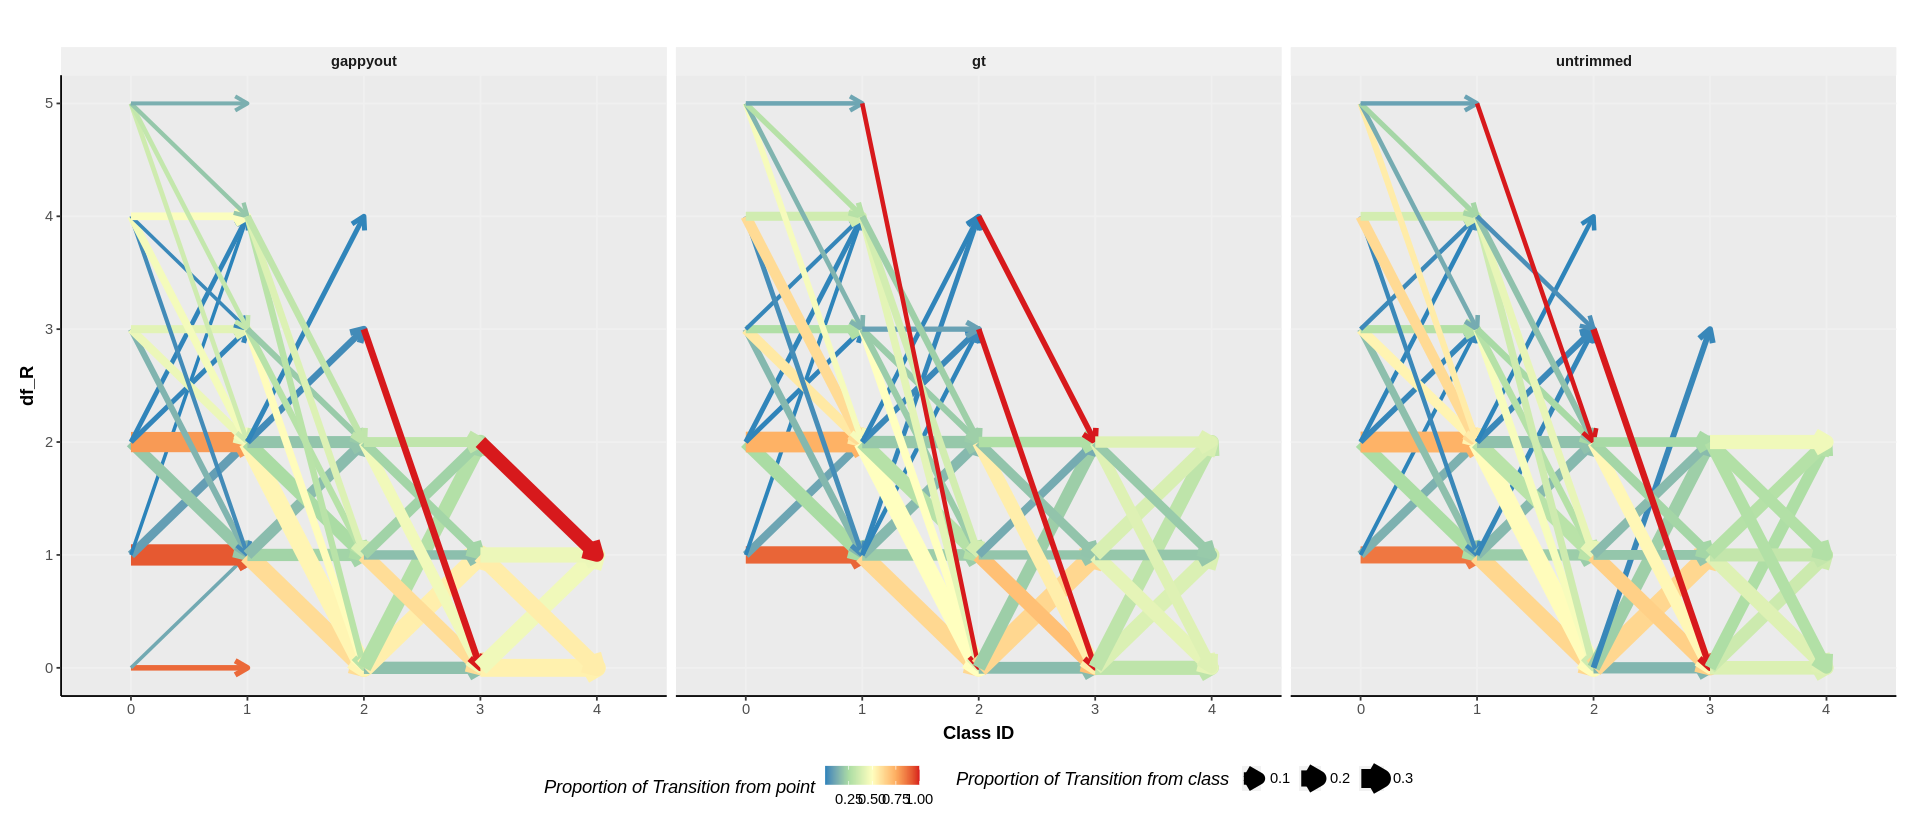

In [9]:
trans_on_df_R <- summary_all_common %>% 
  filter(Num_class < 5) %>%
  select(Type, Locus_name, class_id, Num_class, df_R) %>%
  arrange(Type, Locus_name, class_id) %>%
  group_by(Type, Locus_name) %>%
  mutate(class_id_from = class_id,
         class_id_to = lead(class_id),
         df_R_from = df_R,
         df_R_to = lead(df_R)) %>%
  filter(!is.na(class_id_to), !is.na(df_R_to)) %>%
  ungroup() %>%
  count(class_id_from, class_id_to, df_R_from, df_R_to, Type,  name = "count") %>%
  filter(count > 2) %>%
  group_by(Type, class_id_from) %>%
  mutate(count_on_class = sum(count)) %>%
  ungroup() %>% 
  group_by(Type, class_id_from, df_R_from) %>%
  mutate(count_on_both = sum(count)) %>%
  ungroup() %>% 
  mutate(prop_on_class = count / count_on_class,
         prop_on_both = count / count_on_both)

# stop_at <- summary_all_common %>% 
#   mutate(class_id = as.numeric(class_id)) %>%
#   filter(class_id < 5) %>%
#   select(Type, Locus_name, Num_class_on_mixture, df_R) %>%
#   arrange(Type, Locus_name, Num_class_on_mixture) %>%
#   group_by(Type, Locus_name) %>% 
#   mutate(df_R_on_Max_class = df_R[Num_class_on_mixture]) %>%
#   ungroup() %>%
#   count(Type, Num_class_on_mixture, df_R_on_Max_class, name = "count_stop")
  

options(repr.plot.width = 16, repr.plot.height = 7)
ggplot(trans_on_df_R) +
  # geom_point(data = stop_at, aes(x = as.factor(Num_class_on_mixture), 
  #               y = df_R_on_Max_class, size = sqrt(count_stop))) +
  geom_segment(aes(x = class_id_from, xend = class_id_to,
                   y = df_R_from, yend = df_R_to,
                   size = prop_on_class, color = prop_on_both),
               arrow = arrow(length = unit(0.3,"cm"))) +
  labs(x = "Class ID", y = "df_R", 
           size = "Proportion of Transition from class", 
           color = "Proportion of Transition from point") +
  theme_Publication() +
  scale_colour_gradientn(colours = rev(brewer.pal(5, 'Spectral'))) +
  # scale_size(range = c(0.5, 5)) +
  facet_wrap(~Type)

`summarise()` has grouped output by 'class_id'. You can override using the `.groups` argument.


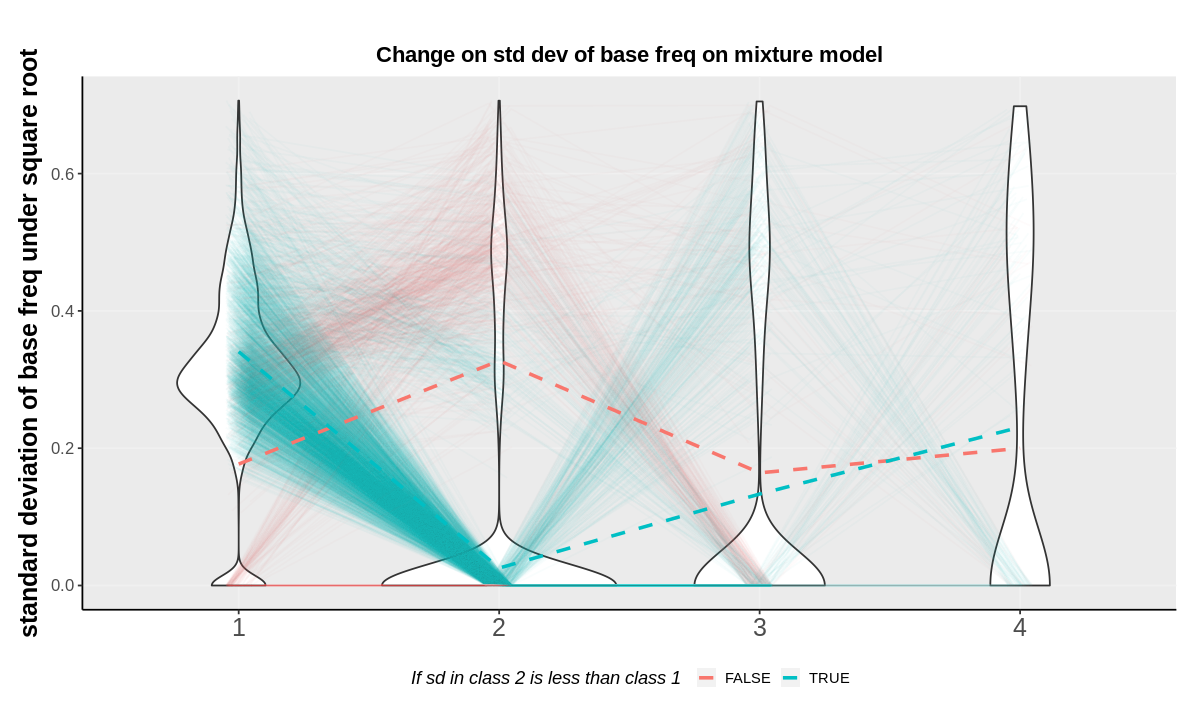

In [10]:
options(repr.plot.width = 10, repr.plot.height = 6)

diff_freq <- summary_all_common %>% filter(If_mix == TRUE & Model == "Mixture") %>% 
    mutate(name = paste(Type, Locus_name, sep = "_")) %>%
    select(name, class_id, Num_class_on_mixture, sd_base_freq) %>% 
    pivot_wider(names_from = class_id, values_from = sd_base_freq, names_prefix = "class_") %>% 
    mutate(diff_12 = class_1 - class_2,
          If_add = (diff_12 > 0)) %>% 
    select(name, diff_12, If_add) %>% 
    separate(name, into = c("Type", "Locus_name"), sep = "_")

test_freq_change <- left_join(summary_all_common, diff_freq, by = c("Type", "Locus_name")) %>%
    select(Type, Model, Locus_name, class_id, If_mix, Num_class_on_mixture, sd_base_freq, diff_12, If_add) %>% 
    filter(If_mix == TRUE & Model == "Mixture")

avg_data <- test_freq_change %>% filter(If_mix == TRUE & Model == "Mixture") %>% 
    group_by(class_id, If_add) %>% summarise(avg_Interval_base_freq = mean(sqrt(sd_base_freq)))

ggplot(data = test_freq_change,
       mapping = aes(x = as.factor(class_id), y = sqrt(sd_base_freq)), color = If_add) +
  geom_violin() +
  # geom_violindot(dots_size = 0.8,
  #                position_dots = position_dodge(0.1),
  #                flip = c(1)) +
  geom_line(mapping = aes(group = interaction(Locus_name, Type), color = If_add),
            alpha = 0.025,
            position = position_dodge(0.1), linetype = "solid") +
  geom_line(data = avg_data, aes(y = avg_Interval_base_freq, group= If_add, color = If_add), 
            linetype = "dashed", lwd = 1) +  # add the average line
  theme_Publication() +
  theme(legend.position = "bottom",
        axis.text.x = element_text(size = 15),
        axis.title.y = element_text(size = 15),
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 10)) +
  ggtitle("Change on std dev of base freq on mixture model") +
  labs(x = "Class ID", y = "standard deviation of base freq under square root",
       color = "If sd in class 2 is less than class 1")


`summarise()` has grouped output by 'class_id'. You can override using the `.groups` argument.
Warning message:
“Removed 58 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 58 rows containing missing values (`geom_line()`).”


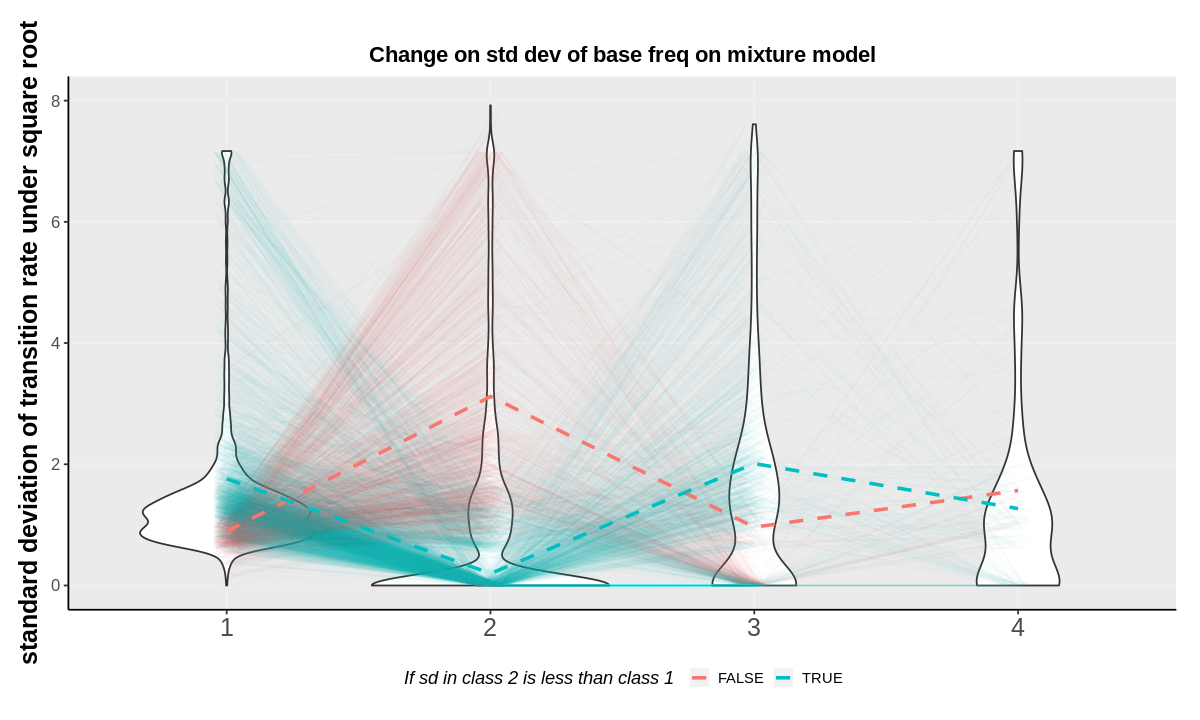

In [11]:
options(repr.plot.width = 10, repr.plot.height = 6)
diff_freq <- summary_all_common %>% filter(If_mix == TRUE & Model == "Mixture") %>% 
    mutate(name = paste(Type, Locus_name, sep = "_")) %>%
    select(name, class_id, Num_class_on_mixture, sd_R) %>% 
    pivot_wider(names_from = class_id, values_from = sd_R, names_prefix = "class_") %>% 
    mutate(diff_12 = class_1 - class_2,
          If_add = (diff_12 > 0)) %>% 
    select(name, diff_12, If_add) %>% 
    separate(name, into = c("Type", "Locus_name"), sep = "_")

test_freq_change <- left_join(summary_all_common, diff_freq, by = c("Type", "Locus_name")) %>%
    select(Type, Model, Locus_name, class_id, If_mix, Num_class_on_mixture, sd_R, diff_12, If_add) %>% 
    filter(If_mix == TRUE & Model == "Mixture")

avg_data <- test_freq_change %>% filter(If_mix == TRUE & Model == "Mixture") %>% 
    group_by(class_id, If_add) %>% summarise(avg_Interval_base_freq = mean(sqrt(sd_R)))

ggplot(data = test_freq_change,
       mapping = aes(x = as.factor(class_id), y = sqrt(sd_R)), color = If_add) +
  geom_violin() +
  # geom_violindot(dots_size = 0.8,
  #                position_dots = position_dodge(0.1),
  #                flip = c(1)) +
  geom_line(mapping = aes(group = interaction(Locus_name, Type), color = If_add),
            alpha = 0.025,
            position = position_dodge(0.1), linetype = "solid") +
  geom_line(data = avg_data, aes(y = avg_Interval_base_freq, group= If_add, color = If_add), 
            linetype = "dashed", lwd = 1) +  # add the average line
  theme_Publication() +
  theme(legend.position = "bottom",
        axis.text.x = element_text(size = 15),
        axis.title.y = element_text(size = 15),
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 10)) +
  ggtitle("Change on std dev of base freq on mixture model") +
  ylim(0, 8) +
    labs(x = "Class ID", y = "standard deviation of transition rate under square root",
       color = "If sd in class 2 is less than class 1")


In [12]:
diff_sd_R <- summary_all_common %>% filter(If_mix == TRUE & Model == "Mixture" & Num_class_on_mixture == 2 & Type == "gt") %>% 
    select(Type, Locus_name, class_id, Num_class_on_mixture, sd_R) %>% 
    pivot_wider(names_from = class_id, values_from = sd_R, names_prefix = "class_") %>% 
    mutate(diff_sd_R_12 = class_1 - class_2,
           ratio_sd_R_12 = 2 * diff_sd_R_12 / (class_1 + class_2),
           If_add_sd_R = (diff_sd_R_12 > 0),
           If_any_zero_sd_R = (class_1 == 0 | class_2 == 0))

class_cols <- grep("^class_", names(diff_sd_R), value = TRUE)
diff_sd_R <- diff_sd_R %>%
  rename_with(~paste0(., "_sd_R"), .cols = all_of(class_cols))

Q_summary <- right_join(summary_all_common_diff %>% select(-Num_class_on_mixture), diff_sd_R, by = c("Type", "Locus_name")) %>% 
    na.omit()

diff_sd_base_freq <- summary_all_common %>% filter(If_mix == TRUE & Model == "Mixture" & Num_class_on_mixture == 2 & Type == "gt") %>% 
    select(Type, Locus_name, class_id, Num_class_on_mixture, sd_base_freq) %>% 
    pivot_wider(names_from = class_id, values_from = sd_base_freq, names_prefix = "class_") %>% 
    mutate(diff_sd_bf_12 = class_1 - class_2,
           ratio_sd_bf_12 = 2*diff_sd_bf_12 / (class_1 + class_2),
          If_add_sd_bf = (diff_sd_bf_12 > 0),
          If_any_zero_sd_bf = (class_1 == 0 | class_2 == 0))

class_cols <- grep("^class_", names(diff_sd_base_freq), value = TRUE)
diff_sd_base_freq <- diff_sd_base_freq %>%
  rename_with(~paste0(., "_sd_bf"), .cols = all_of(class_cols))

Q_summary <- right_join(Q_summary, diff_sd_base_freq, by = c("Type", "Locus_name", "Num_class_on_mixture")) %>% 
    na.omit()

In [13]:
# options(repr.plot.width = 15, repr.plot.height = 15)
# ggpairs(Q_summary %>% select(d_AIC, d_Likelihood, d_Tree_Length, d_prop_int, Ntaxa, 
#                              Percent_parsimony_informative, Mean,
#                              class_1_sd_R, class_2_sd_R, diff_sd_R_12, If_add_sd_R,
#                              class_1_sd_bf, class_2_sd_bf, diff_sd_bf_12, If_add_sd_bf))

In [14]:
summary_all_common %>%
    select(base_freq, class_id) %>% 
    mutate(base_max = sapply(base_freq, which.max),
           dup_count = sapply(base_freq, function(x) sum(duplicated(x)))) %>% 
    count(base_max, dup_count) %>% 
    pivot_wider(names_from = base_max, values_from = n)

dup_count,1,2,3,4
<int>,<int>,<int>,<int>,<int>
0,11750,233,278,11720
1,22,1,NA,13
3,7886,NA,NA,NA


In [15]:
summary_all_common %>% filter(df_R >= 3) %>%
    select(R, class_id) %>% 
    unnest_wider(R) %>% 
    group_by(class_id) %>%
    summarise_all(mean, na.rm = TRUE)


summary_all_common %>% filter(df_R < 2) %>%
    select(R, class_id) %>% 
    unnest_wider(R) %>% 
    group_by(class_id) %>%
    summarise_all(mean, na.rm = TRUE)

# summary_all_common %>% filter(Model == "Mixture" & df_R < 2) %>%
#     select(class) %>% unique()

class_id,A-C,A-G,A-T,C-G,C-T,G-T
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1.09409,3.272865,0.695028,1.353465,3.363103,1.000000
1,1.07315,3.616823,2.546431,1.305712,4.731182,3.299737
2,1.00000,7.009612,8.258460,5.532320,9.201090,9.204918
3,1.00000,8.755777,11.217782,7.840011,14.904954,15.391599
4,1.00000,7.475221,32.338665,1.035320,14.327464,32.373985


class_id,A-C,A-G,A-T,C-G,C-T,G-T
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,3.539907,1,1,3.539907,1
1,1,4.732642,1,1,4.732642,1
2,1,8.695192,1,1,8.695192,1
3,1,12.113530,1,1,12.113530,1
4,1,9.658227,1,1,9.658227,1


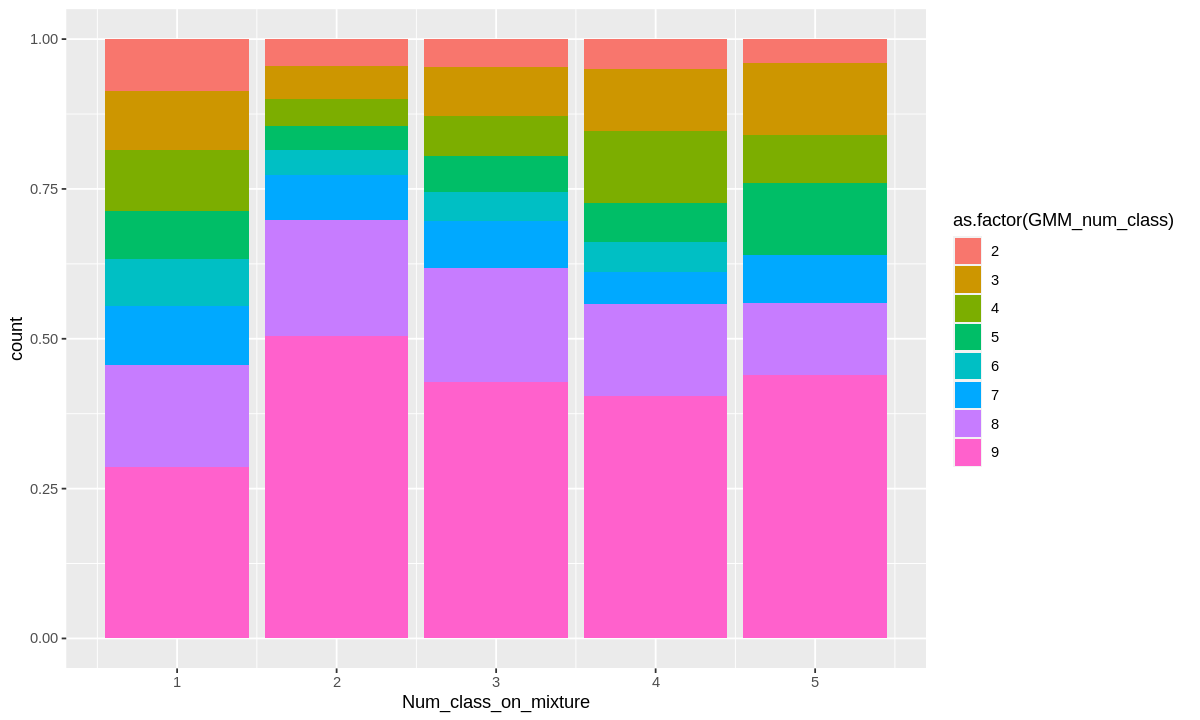

In [16]:
summary_all_common %>% 
    ggplot(aes(x = Num_class_on_mixture, fill = as.factor(GMM_num_class))) +
    geom_bar(position = "fill")

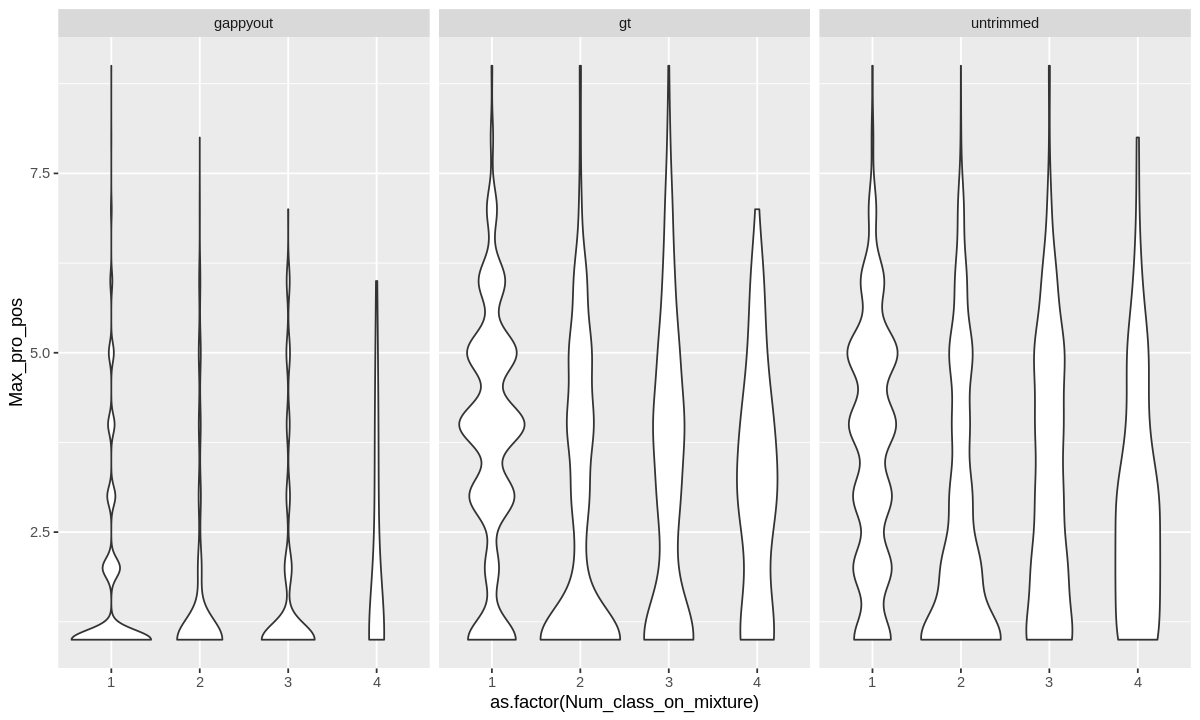

In [17]:
summary_all_common %>% 
    filter(class_id == 1) %>%
    ggplot(aes(x = as.factor(Num_class_on_mixture), y = Max_pro_pos)) +
    geom_violin() +
    facet_wrap(~Type)

In [18]:
summary_all_common_diff <- summary_all_common_diff %>%
    mutate(GC_content = map_dbl(real_base_freq, ~sum(as.numeric(.x[3:4]))/sum(as.numeric(.x[1:4]))))

In [19]:
calc_heterogeneity <- function(base_freq, real_base_freq) {
  base_freq <- as.numeric(base_freq)
  real_base_freq <- as.numeric(real_base_freq)
  adjusted_real_base_freq <- real_base_freq[1:4] * sum(real_base_freq) / sum(real_base_freq[1:4])
  diff <- abs(base_freq - adjusted_real_base_freq)
  return(sum(diff))
}

summary_all_common <- summary_all_common %>% 
      mutate(Hetero_base_freq = map2_dbl(base_freq, real_base_freq, calc_heterogeneity))

In [20]:
summary_all_common <- summary_all_common %>% group_by(Type, Locus_name) %>%
    mutate(If_hetero_in_single = ifelse(Model == "One_class" & Hetero_base_freq > 0.01, TRUE, FALSE)) %>%
    mutate(If_hetero_in_single = ifelse(any(If_hetero_in_single), TRUE, FALSE)) %>%
    ungroup()

In [21]:
trans_on_df_R <- summary_all_common %>% 
  filter(Num_class < 5 & Type == "gt") %>%
  select(Locus_name, class_id, Num_class, df_R) %>%
  arrange(Locus_name, class_id) %>%
  group_by(Locus_name) %>%
  mutate(class_id_from = class_id,
         class_id_to = lead(class_id),
         df_R_from = df_R,
         df_R_to = lead(df_R)) %>%
  filter(!is.na(class_id_to), !is.na(df_R_to)) %>%
  ungroup() %>%
  count(class_id_from, class_id_to, df_R_from, df_R_to, name = "count") %>% 
  group_by(class_id_from) %>%
  mutate(count_on_class = sum(count)) %>%
  ungroup() %>% 
  group_by(class_id_from, df_R_from) %>%
  mutate(count_on_both = sum(count)) %>%
  ungroup() %>% 
  mutate(prop_on_class = count / count_on_class,
         prop_on_both = count / count_on_both)

plot_df <- ggplot(trans_on_df_R) +
  geom_segment(aes(x = class_id_from, xend = class_id_to,
                   y = df_R_from, yend = df_R_to,
                   size = prop_on_class, color = prop_on_both),
               arrow = arrow(length = unit(0.3,"cm"))) +
  labs(x = "Class ID on mixture model", y = "degree of freedom in transition rate", 
           size = "Ratio of transit from class", 
           color = "Ratio of transit from point") +
  theme_Publication() +
  scale_colour_gradientn(colours = rev(brewer.pal(5, 'Spectral'))) +
  theme(legend.position="bottom") +
  guides(color=guide_colourbar(barwidth=5.5))



plot_bh <- summary_all_common %>% filter(Num_class <= 4) %>%
    ggplot(aes(x = as.factor(class_id), y = Hetero_base_freq, fill = If_hetero_in_single)) +
    geom_boxplot() +
    theme_Publication() +
    labs(x = "Class ID on mixture model", y = "base freq heterogeneity",
         fill = "FO is used in one-class model algorithm") +
    ylim(0, 1.15)

plot_tq <- summary_all_common %>% filter(Num_class <= 4) %>%
    ggplot(aes(x = as.factor(class_id), y = -trace_Q)) +
    geom_violin() +
    theme_Publication() +
    labs(x = "Class ID on mixture model", y = "-(trace(Q) + 4)") +
    ylim(-1,4)

Warning message:
“Removed 92 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 473 rows containing non-finite values (`stat_ydensity()`).”


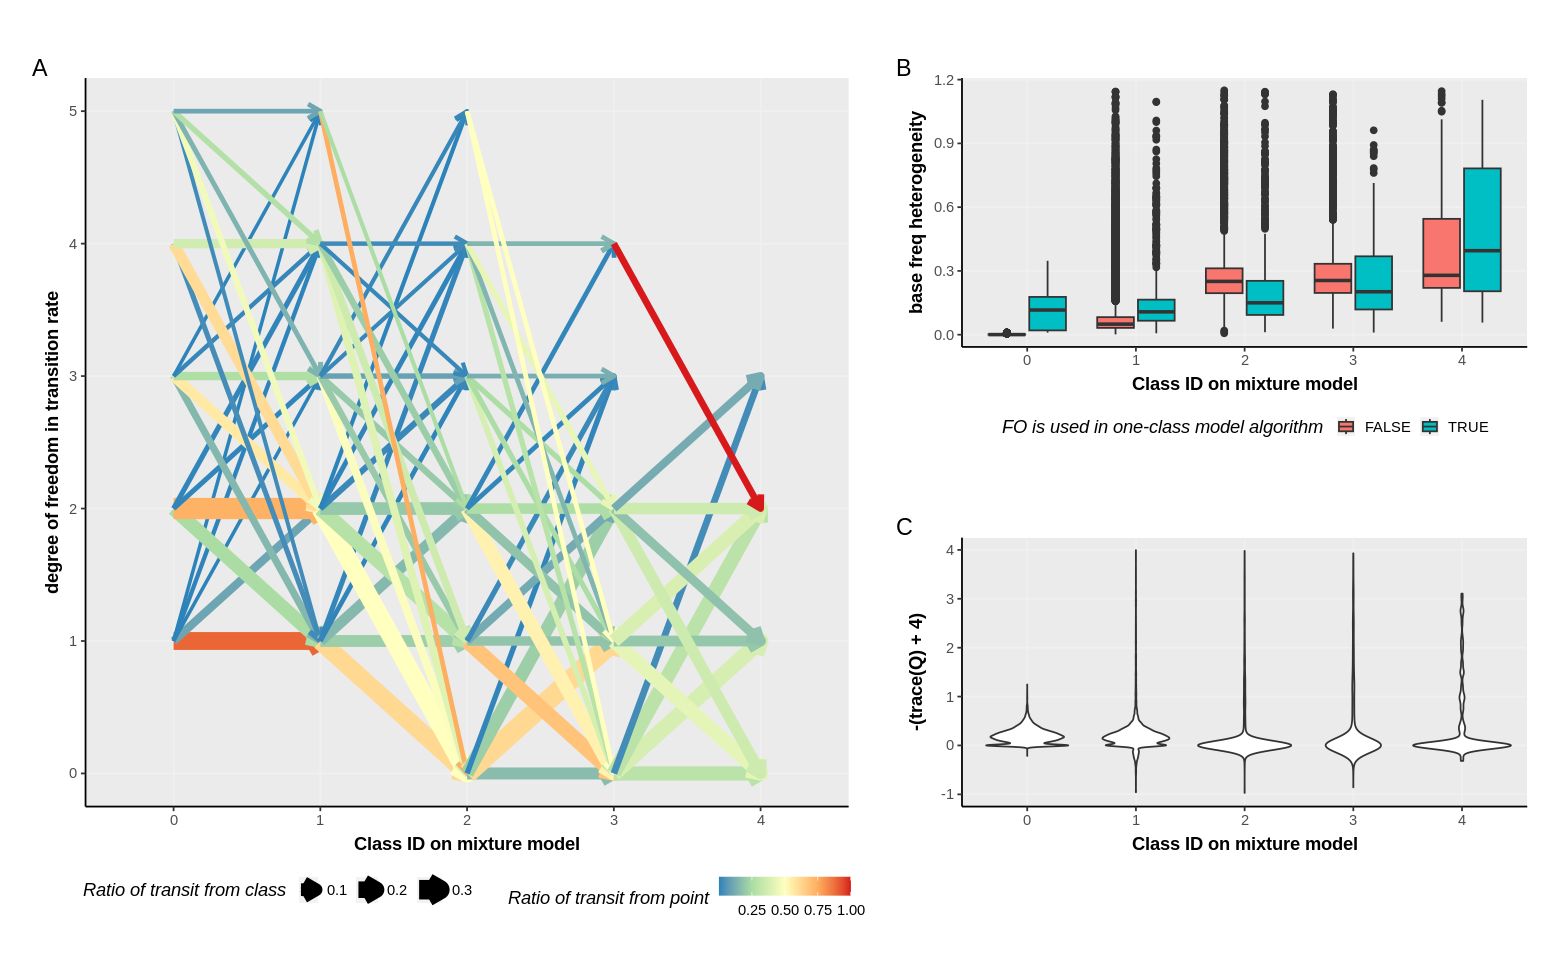

In [22]:
options(repr.plot.width = 13, repr.plot.height = 8)
plot_df + (plot_bh / plot_tq)  + plot_layout(width = c(2.7, 2)) +
  plot_annotation(tag_levels = "A") & 
  theme(plot.tag = element_text(size = 14)) 

In [24]:
# avg_data <- summary_all_common %>% filter(If_mix == TRUE & Model == "Mixture") %>% 
#     group_by(class_id) %>% summarise(avg_Hetero_base_freq = mean(Hetero_base_freq))

# ggplot(data = summary_all_common %>% filter(Model == "Mixture"),,
#        aes(x = as.factor(class_id), y = Hetero_base_freq)) +
#   geom_violin() +
#   # geom_violindot(dots_size = 0.8,
#   #                position_dots = position_dodge(0.1),
#   #                flip = c(1)) +
#   geom_line(mapping = aes(group = interaction(Locus_name, Type)),
#             alpha = 0.025,
#             position = position_dodge(0.1), linetype = "solid") +
#   geom_line(data = avg_data, aes(y = avg_Hetero_base_freq), 
#             linetype = "dashed", lwd = 1) +  # add the average line
#   theme_Publication() +
#   theme(legend.position = "bottom",
#         axis.text.x = element_text(size = 15),
#         axis.title.y = element_text(size = 15),
#         axis.title.x = element_blank(),
#         axis.text.y = element_text(size = 10)) +
#   ggtitle("Change on std dev of base freq on mixture model") +
#     labs(x = "Class ID", y = "standard deviation of transition rate under square root",
#        color = "If sd in class 2 is less than class 1")


In [32]:
summary_all_common %>% filter(Hetero_base_freq > 1) %>% 
    select(trace_Q, Model_string, base_freq, R)

trace_Q,Model_string,base_freq,R
<dbl>,<chr>,<list>,<list>
-18.2115599,"MIX{TPM3u+FO,F81+FO}+I+R2","0.92873600, 0.00995576, 0.04489720, 0.01641080","1, 1, 1, 1, 1, 1"
-8.2021100,"MIX{TPM3u+FO,TIM3+FO}+G","0.92060600, 0.00749145, 0.05411500, 0.01778750","1.000000, 5.130500, 0.531799, 1.000000, 5.130500, 0.531799"
-48.9867773,"MIX{HKY+FO,JC+FO,F81+FO,F81+FO}+G","9.99375e-05, 1.48336e-02, 1.40021e-02, 9.71064e-01","1, 1, 1, 1, 1, 1"
-3.5699564,"MIX{TPM3u+FO,TN+FO}+I+G","0.0476808, 0.0901944, 0.0431168, 0.8190080","1.000000, 4.038230, 0.757203, 1.000000, 4.038230, 0.757203"
-3.4872430,"MIX{HKY+FO,K81u+FO}+G","0.077939300, 0.299883000, 0.621900000, 0.000278117","1.00000, 4.19742, 1.00000, 1.00000, 4.19742, 1.00000"
-34.7165760,"MIX{HKY+FO,HKY+FO,TPM3+FO}+G","0.79226400, 0.03715570, 0.00433154, 0.16624800","1.0000, 41.2037, 1.0000, 1.0000, 41.2037, 1.0000"
-8.7268932,"MIX{TVM+FO,K80+FO,TPM3u+FO}+I+G","0.0591821, 0.0391728, 0.0556528, 0.8459920","1.0000, 100.0000, 11.0233, 1.0000, 100.0000, 11.0233"
-824.1175393,"MIX{TPM3u+FO,K80+FO,TPM2u+FO}+R2","0.00146663, 0.00010003, 0.00010003, 0.99833300","1.00000, 3.97568, 5.60395, 1.00000, 3.97568, 5.60395"
-6.3618226,"MIX{TPM2u+FO,TPM2u+FO,F81+FO}+G","0.0455321, 0.0556926, 0.0611852, 0.8375900","1, 1, 1, 1, 1, 1"
